In [15]:
# Analog: https://www.earthdatascience.org/courses/earth-analytics-python/using-apis-natural-language-processing-twitter/calculate-tweet-word-bigrams-networks-in-python/
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections

import tweepy as tw
import nltk
from nltk import bigrams
from nltk.corpus import stopwords
import re
import networkx as nx

import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

In [16]:
import pymongo

client = pymongo.MongoClient("mongodb://127.0.0.1:27017/")

db = client['Twitter']
All_Tweets_collection = db['Twitter_mdp']


In [3]:
####################################
# Laden von Dokumenten aus Mongodb #
####################################

# 1.) find_one() bringt dict, aber nur ein Dokument! 

#tweets = All_Tweets_collection.find_one()


In [17]:
# 2.) find() funktioniert wie query in Mongodb - aber gibt liste von dicts zurück

tweets=[]

for Tweet in All_Tweets_collection.aggregate([ {"$sample": {"size": 50 }}], 
                                     allowDiskUse=True
                                   ):
    tweets.append(Tweet)
    
type(tweets)
len(tweets)

50

In [5]:
# Zum Verständnis: liste (tweets) von dictionarys (tweet) -> um an text eines Tweets zu kommen tweet["text"]

tweets_text=[]
for tweet in tweets:
    tweets_text.append(tweet["text"])

tweets_text[8]

'@MahatmaDjango @DLFmedien Ich sehe schon, ich habe die Gänsefüße und die indirekte Rede bei der Überschrift wohl überlesen. \n\nAch ja...'

In [24]:
def remove_url(txt):
    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

# Remove URLs
tweets_no_urls = [remove_url(tweet["text"]) for tweet in tweets]

# Create a sublist of lower case words for each tweet
words_in_tweet = [tweet.lower().split() for tweet in tweets_no_urls]

# Download stopwords
#nltk.download('stopwords')
stop_words = set(stopwords.words('german'))
#stop_words2 = set(stopwords.words('english'))

# Remove stop words from each tweet list of words
tweets_nsw = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in words_in_tweet]

# Remove collection words
#collection_words = ['climatechange', 'climate', 'change']

#tweets_nsw_nc = [[w for w in word if not w in collection_words]
#                 for word in tweets_nsw]




In [26]:
words_in_tweet

[['rt',
  'szauto',
  'eukommission',
  'fordert',
  'manipulierte',
  'vwdiesel',
  'sollen',
  'von',
  'den',
  'straen',
  'verschwinden',
  'wenn',
  'sie',
  'nicht',
  'umgerstet',
  'werden'],
 ['ronaldelzenga',
  'absolut',
  'kooperation',
  'mit',
  'frankreich',
  'schliet',
  'zusammenarbeit',
  'mit',
  'anderen',
  'staaten',
  'keinesfalls',
  'aus'],
 ['albrechteger', 'andrejhunko', 'heikomaas', 'maduro', 'mit', 'merkelraute'],
 ['rt',
  'bsannefrank',
  'wer',
  'den',
  'anschlag',
  'von',
  'halle0910',
  'unvorstellbar',
  'oder',
  'alarmzeichen',
  'nennt',
  'und',
  'von',
  'einem',
  'einzeltter',
  'spricht',
  'verkennt'],
 ['rt',
  'denanews',
  'dena',
  'derbdi',
  'amp',
  'projektesys',
  'diskutieren',
  'miteinander',
  'wie',
  'schaffen',
  'wir',
  'die',
  'energiewende',
  'verfolgen',
  'sie',
  'die',
  'ausgebuchte',
  've'],
 ['ich',
  'freue',
  'mich',
  'sehr',
  'dass',
  'es',
  'bald',
  'die',
  'mglichkeit',
  'geben',
  'wird',
  '

In [19]:
tweets_nsw

[['rt',
  'szauto',
  'eukommission',
  'fordert',
  'manipulierte',
  'vwdiesel',
  'sollen',
  'straen',
  'verschwinden',
  'umgerstet'],
 ['ronaldelzenga',
  'absolut',
  'kooperation',
  'frankreich',
  'schliet',
  'zusammenarbeit',
  'staaten',
  'keinesfalls'],
 ['albrechteger', 'andrejhunko', 'heikomaas', 'maduro', 'merkelraute'],
 ['rt',
  'bsannefrank',
  'wer',
  'anschlag',
  'halle0910',
  'unvorstellbar',
  'alarmzeichen',
  'nennt',
  'einzeltter',
  'spricht',
  'verkennt'],
 ['rt',
  'denanews',
  'dena',
  'derbdi',
  'amp',
  'projektesys',
  'diskutieren',
  'miteinander',
  'schaffen',
  'energiewende',
  'verfolgen',
  'ausgebuchte',
  've'],
 ['freue',
  'bald',
  'mglichkeit',
  'geben',
  'opfer',
  'staatlichen',
  'homosexuellenverfolgu'],
 ['rt',
  'cdunrwfraktion',
  'landarztgesetz',
  'meilenstein',
  'gelegt',
  'medizinische',
  'versorgung',
  'lndlichen',
  'raumes',
  's'],
 ['knstlerin',
  'elfie',
  'clement',
  'macht',
  'installation',
  'rhein

In [21]:
# Create list of lists containing bigrams in tweets
terms_bigram = [list(bigrams(tweet)) for tweet in tweets_nsw]

# View bigrams for the first tweet
terms_bigram

[[('rt', 'szauto'),
  ('szauto', 'eukommission'),
  ('eukommission', 'fordert'),
  ('fordert', 'manipulierte'),
  ('manipulierte', 'vwdiesel'),
  ('vwdiesel', 'sollen'),
  ('sollen', 'straen'),
  ('straen', 'verschwinden'),
  ('verschwinden', 'umgerstet')],
 [('ronaldelzenga', 'absolut'),
  ('absolut', 'kooperation'),
  ('kooperation', 'frankreich'),
  ('frankreich', 'schliet'),
  ('schliet', 'zusammenarbeit'),
  ('zusammenarbeit', 'staaten'),
  ('staaten', 'keinesfalls')],
 [('albrechteger', 'andrejhunko'),
  ('andrejhunko', 'heikomaas'),
  ('heikomaas', 'maduro'),
  ('maduro', 'merkelraute')],
 [('rt', 'bsannefrank'),
  ('bsannefrank', 'wer'),
  ('wer', 'anschlag'),
  ('anschlag', 'halle0910'),
  ('halle0910', 'unvorstellbar'),
  ('unvorstellbar', 'alarmzeichen'),
  ('alarmzeichen', 'nennt'),
  ('nennt', 'einzeltter'),
  ('einzeltter', 'spricht'),
  ('spricht', 'verkennt')],
 [('rt', 'denanews'),
  ('denanews', 'dena'),
  ('dena', 'derbdi'),
  ('derbdi', 'amp'),
  ('amp', 'projektesy

In [8]:
# Original tweet without URLs
tweets_no_urls[9]

'willemL87 Das Paket ist grer Es wird eine berprfung und Vereinheitlichung der Messstellen geben und die Binne'

In [13]:
terms_bigram

[[('meldung', 'dpa'),
  ('dpa', 'besttigen'),
  ('besttigen', 'euro2016'),
  ('euro2016', 'diemanschaft'),
  ('diemanschaft', 'gerita'),
  ('gerita', 'jederfuerjeden')],
 [('rt', 'ulfposh'),
  ('ulfposh', 'chemnitz'),
  ('chemnitz', 'kthen'),
  ('kthen', 'hambacher'),
  ('hambacher', 'forst'),
  ('forst', 'beerdigung'),
  ('beerdigung', 'nidal'),
  ('nidal', 'r'),
  ('r', 'berall'),
  ('berall', 'polizisten'),
  ('polizisten', 'angespuckt'),
  ('angespuckt', 'getreten'),
  ('getreten', 'beschimpft'),
  ('beschimpft', 'gedem')],
 [('helvetica', 'awesome'),
  ('awesome', 'btw'),
  ('btw', 'i'),
  ('i', 'tapped'),
  ('tapped', 'leave'),
  ('leave', 'a'),
  ('a', 'review'),
  ('review', 'on'),
  ('on', 'that'),
  ('that', 'initial'),
  ('initial', 'screen'),
  ('screen', 'and'),
  ('and', 'nothing'),
  ('nothing', 'happened')],
 [('rt', 'ostritzer'),
  ('ostritzer', 'kampf'),
  ('kampf', 'nibelungen'),
  ('nibelungen', 'bleibt'),
  ('bleibt', 'verboten'),
  ('verboten', 'verwaltungsgericht

In [10]:
# Flatten list of bigrams in clean tweets
bigrams = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

bigram_counts.most_common(20)

[(('rt', 'spdbt'), 2),
 (('extra', '3'), 2),
 (('meldung', 'dpa'), 1),
 (('dpa', 'besttigen'), 1),
 (('besttigen', 'euro2016'), 1),
 (('euro2016', 'diemanschaft'), 1),
 (('diemanschaft', 'gerita'), 1),
 (('gerita', 'jederfuerjeden'), 1),
 (('rt', 'ulfposh'), 1),
 (('ulfposh', 'chemnitz'), 1),
 (('chemnitz', 'kthen'), 1),
 (('kthen', 'hambacher'), 1),
 (('hambacher', 'forst'), 1),
 (('forst', 'beerdigung'), 1),
 (('beerdigung', 'nidal'), 1),
 (('nidal', 'r'), 1),
 (('r', 'berall'), 1),
 (('berall', 'polizisten'), 1),
 (('polizisten', 'angespuckt'), 1),
 (('angespuckt', 'getreten'), 1)]

In [11]:
bigram_df = pd.DataFrame(bigram_counts.most_common(20),
                             columns=['bigram', 'count'])

bigram_df

,bigram,count
0,"(rt, cducsubt)",6018
1,"(rt, cdu)",3232
2,"(herzlichen, glckwunsch)",2116
3,"(of, the)",1997
4,"(angela, merkel)",1816
5,"(rt, bmgbund)",1726
6,"(rt, bmwibund)",1392
7,"(heute, abend)",1226
8,"(danke, fr)",1150
9,"(for, the)",1057


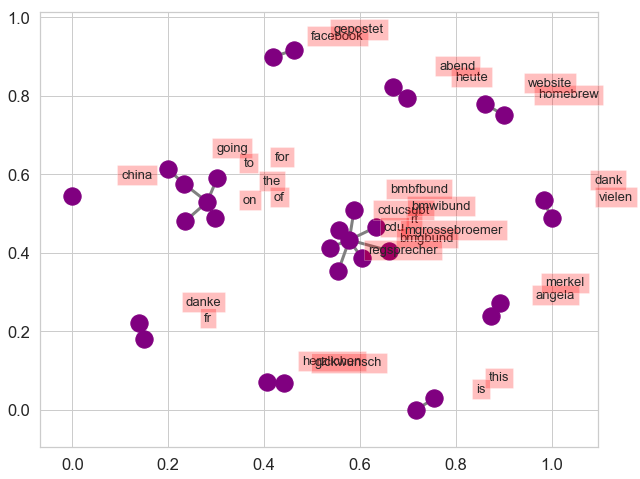

In [12]:
# Create dictionary of bigrams and their counts
d = bigram_df.set_index('bigram').T.to_dict('records')

# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

G.add_node("china", weight=100)

fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=1)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()


## EDA von Twitter - Erster Eindruck
### Plotte Tweetmenge bestimmter Politiker über Zeit

Code Vorlage:
<https://marcobonzanini.com/2015/04/01/mining-twitter-data-with-python-part-5-data-visualisation-basics/>




In [18]:
tweets=[]

for Tweet in All_Tweets_collection.find({},{"_id":0, "created_at":1, "text":1}):
    tweets.append(Tweet)
    
type(tweets)


list